In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

In [2]:
flujos_loc = pd.read_csv('tablas/dd_localidades.csv')
print(flujos_loc.shape[0])
flujos_loc.head(3)

377610


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076


In [3]:
locs = cargar_datos_geo()[2][['CODLOC', 'geometry']]
locs.head(3)

,CODLOC,geometry
0,2220,POINT (549273.219 6633915.063)
1,2521,POINT (442454.671 6652273.541)
2,2522,POINT (457921.001 6633361.660)


In [4]:
locs_cod = list(locs.CODLOC)
len(locs_cod) ** 2 - len(locs_cod)

377610

In [5]:
# pega geometrías
dd = flujos_loc.merge(locs, left_on='cod_ori', right_on='CODLOC')
dd = dd.merge(locs, left_on='cod_des', right_on='CODLOC')
dd.drop(['CODLOC_x', 'CODLOC_y'], axis=1, inplace=True)
dd.rename({'geometry_x':'geom_ori', 'geometry_y':'geom_des'}, axis=1, inplace=True)

dd.head()

# exporta CSV con geometrías puntuales para mapa de flujos
#dd.to_csv('capas/loc_lines.csv', index=False)

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,geom_ori,geom_des
0,10202220,1020,2220,1304729,40657,635.0,583715,POINT (573082.248 6145008.434),POINT (549273.219 6633915.063)
1,25212220,2521,2220,12200,40657,NaN,137927,POINT (442454.671 6652273.541),POINT (549273.219 6633915.063)
2,25222220,2522,2220,2659,40657,NaN,111408,POINT (457921.001 6633361.660),POINT (549273.219 6633915.063)
3,26212220,2621,2220,2531,40657,NaN,106867,POINT (468458.270 6601361.867),POINT (549273.219 6633915.063)
4,27212220,2721,2220,380,40657,NaN,58392,POINT (502880.928 6648162.053),POINT (549273.219 6633915.063)


In [6]:
print(flujos_loc.shape)
flujos_loc.head()

(377610, 7)


,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.0,583715
1,10202521,1020,2521,1304729,12200,90.0,612802
2,10202522,1020,2522,1304729,2659,17.0,617076
3,10202621,1020,2621,1304729,2531,9.0,595785
4,10202721,1020,2721,1304729,380,NaN,628213


In [7]:
flujos_loc.loc[flujos_loc.personas_mig.isna(), 'personas_mig'] = 0.001
flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m
0,10202220,1020,2220,1304729,40657,635.000,583715
1,10202521,1020,2521,1304729,12200,90.000,612802
2,10202522,1020,2522,1304729,2659,17.000,617076
3,10202621,1020,2621,1304729,2531,9.000,595785
4,10202721,1020,2721,1304729,380,0.001,628213


In [8]:
flujos_loc['log_dist'] = np.log(flujos_loc.distancia_m)
flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168
1,10202521,1020,2521,1304729,12200,90.000,612802,13.325797
2,10202522,1020,2522,1304729,2659,17.000,617076,13.332747
3,10202621,1020,2621,1304729,2531,9.000,595785,13.297635
4,10202721,1020,2721,1304729,380,0.001,628213,13.350635


In [9]:
# convierte códigos a string para ser correctamente interpretados por el modelo
flujos_loc['cod_ori'] = flujos_loc['cod_ori'].astype(str)
flujos_loc['cod_des'] = flujos_loc['cod_des'].astype(str)

flujos_loc.drop(['cod', 'poblacion_ori', 'poblacion_des', 'distancia_m'],
axis=1, inplace=True)

flujos_loc.head()

,cod_ori,cod_des,personas_mig,log_dist
0,1020,2220,635.000,13.277168
1,1020,2521,90.000,13.325797
2,1020,2522,17.000,13.332747
3,1020,2621,9.000,13.297635
4,1020,2721,0.001,13.350635


In [27]:
n = 350000

In [10]:
formula = "personas_mig ~ cod_ori + log_dist -1"

t0= time.time()

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=flujos_loc, family=sm.families.Poisson()).fit()

t1 = time.time() - t0
print(t1)

MemoryError: Unable to allocate 1.73 GiB for an array with shape (616, 377610) and data type float64

In [29]:
prodSim.summary()

i[3631]           0          0        nan        nan           0           0
cod_ori[3632]           0          0        nan        nan           0           0
cod_ori[3633]           0          0        nan        nan           0           0
cod_ori[3634]           0          0        nan        nan           0           0
cod_ori[3721]           0          0        nan        nan           0           0
cod_ori[3722]           0          0        nan        nan           0           0
cod_ori[3723]           0          0        nan        nan           0           0
cod_ori[3724]           0          0        nan        nan           0           0
cod_ori[3725]           0          0        nan        nan           0           0
cod_ori[3726]           0          0        nan        nan           0           0
cod_ori[3727]           0          0        nan        nan           0           0
cod_ori[3729]           0          0        nan        nan           0           0
cod_ori[3730]           0          0        nan        nan           0           0
cod_ori[3731]           0          0        nan        nan           0           0
cod_ori[3732]           0          0        nan        nan           0           0
cod_ori[3733]           0          0        nan        nan           0           0
cod_ori[3823]           0          0        nan        nan           0           0
cod_ori[3825]           0          0        nan        nan           0           0
cod_ori[3826]           0          0        nan        nan           0           0
cod_ori[3827]           0          0        nan        nan           0           0
cod_ori[3828]           0          0        nan        nan           0           0
cod_ori[3829]           0          0        nan        nan           0           0
cod_ori[3830]           0          0        nan        nan           0           0
cod_ori[3831]           0          0        nan        nan           0           0
cod_ori[3832]           0          0        nan        nan           0           0
cod_ori[3833]           0          0        nan        nan           0           0
cod_ori[3834]           0          0        nan        nan           0           0
cod_ori[3835]           0          0        nan        nan           0           0
cod_ori[3836]           0          0        nan        nan           0           0
cod_ori[3837]           0          0        nan        nan           0           0
cod_ori[3838]           0          0        nan        nan           0           0
cod_ori[3839]           0          0        nan        nan           0           0
cod_ori[3840]           0          0        nan        nan           0           0
cod_ori[3880]           0          0        nan        nan           0           0
cod_ori[3881]           0          0        nan        nan           0           0
cod_ori[3882]           0          0        nan        nan           0           0
cod_ori[3910]           0          0        nan        nan           0           0
cod_ori[3911]           0          0        nan        nan           0           0
cod_ori[3912]           0          0        nan        nan           0           0
cod_ori[3913]           0          0        nan        nan           0           0
cod_ori[3914]           0          0        nan        nan           0           0
cod_ori[3921]           0          0        nan        nan           0           0
cod_ori[3922]           0          0        nan        nan           0           0
cod_ori[3925]           0          0        nan        nan           0           0
cod_ori[3926]           0          0        nan        nan           0           0
cod_ori[3927]           0          0        nan        nan           0           0
cod_ori[3928]           0          0        nan        nan           0           0
cod_ori[3929]           0          0        nan        nan           0           0
cod_ori[3934]         

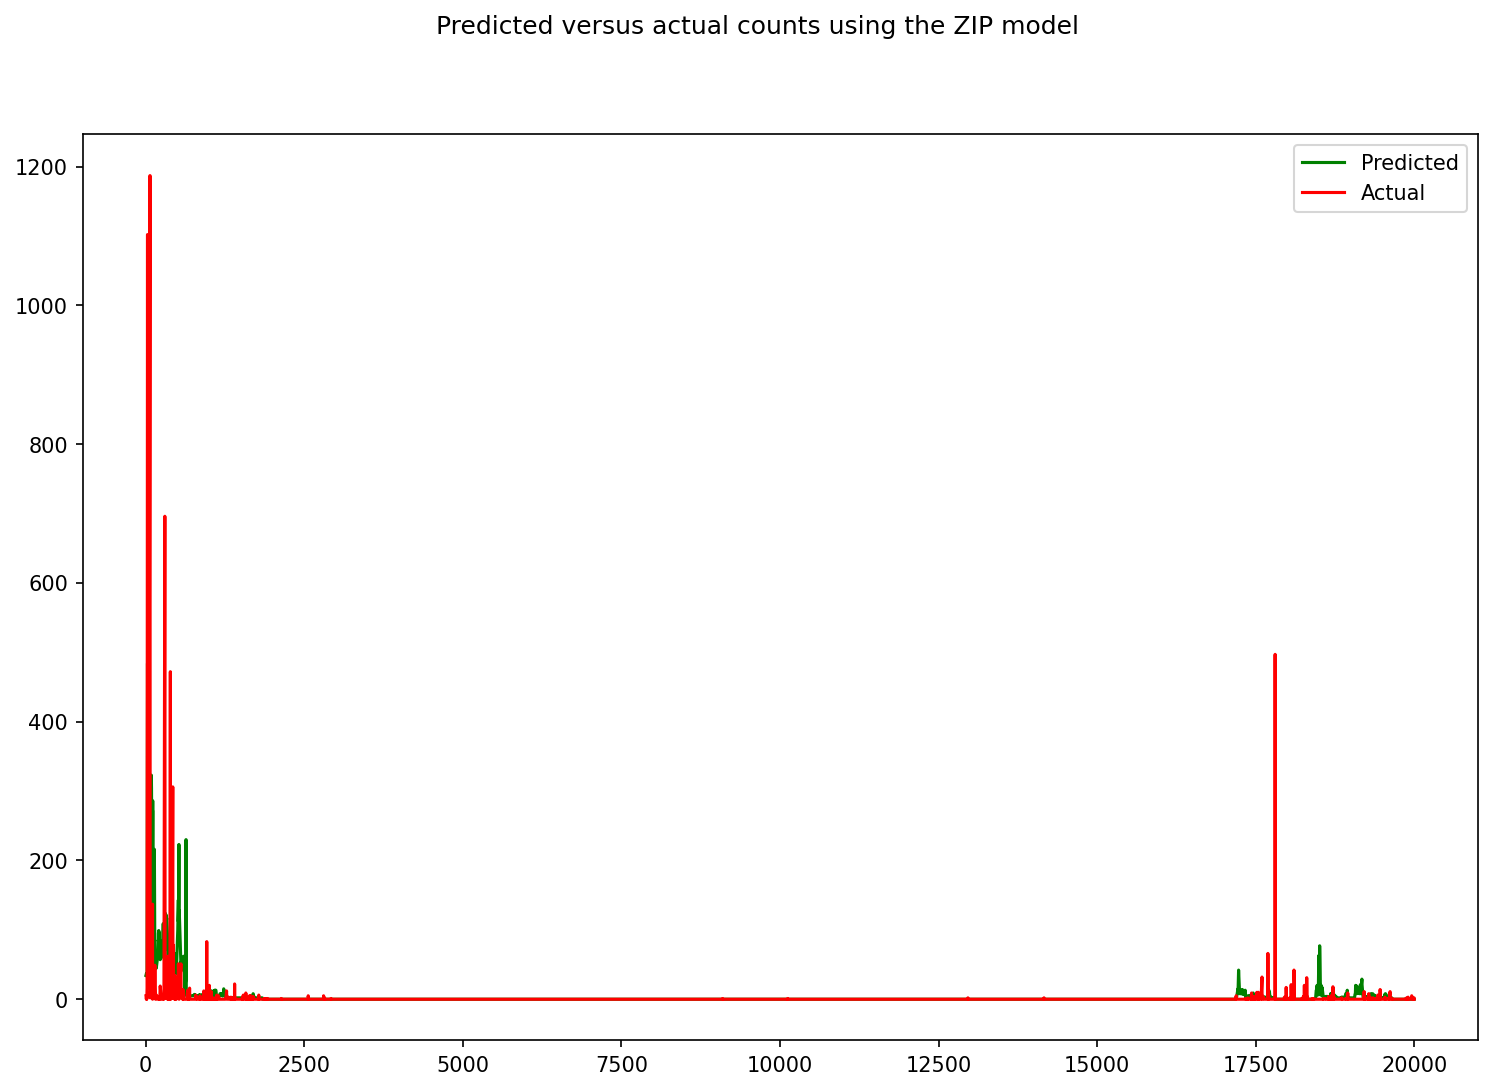

In [54]:
#zero inflated
from patsy import dmatrices


df = flujos_loc

expr = "personas_mig ~ cod_ori + log_dist -1"

mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))


y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

zip_training_results.summary()

zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)

predicted_counts=np.round(zip_predictions)

actual_counts = y_test['personas_mig']

print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))



fig = plt.figure(figsize=(12, 8), dpi=150)

fig.suptitle('Predicted versus actual counts using the ZIP model')

predicted, = plt.plot(X_test.index, predicted_counts, 'g', label='Predicted')

actual, = plt.plot(X_test.index, actual_counts, 'r', label='Actual')

plt.legend(handles=[predicted, actual])

plt.show()

In [1]:
prodSim.summary()

NameError: name 'prodSim' is not defined

In [3]:
# funciones para recuperar parámetros e imprimir
def get_gml_params(model, variables):
    "Accede a los parámetros alfa y beta dentro de los resutaldos del modelo"
    params = [model.params[i] for i in variables]
    params_str = [str(round(i, 4)) for i in params]
    return params, params_str

def print_params(variables, params_list):
    "Imprime los parámetros"
    return print("""alpha ({}) = {}\nbeta ({}) = {}
    """.format(variables[0], params_list[0], variables[1], params_list[1]))

In [4]:
# imprime parámetros
variables= ['cod_ori', 'log_dist']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

NameError: name 'prodSim' is not defined

In [14]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = flujos_loc.groupby('cod_ori')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = flujos_loc.groupby('cod_des')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
flujos_loc = flujos_loc.merge(O_i, left_on='cod_ori', right_index=True)
flujos_loc = flujos_loc.merge(D_j, left_on='cod_des', right_index=True)

flujos_loc.head()

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist,O_i,D_j
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168,55484.172,1043.544
1229,25212220,2521,2220,12200,40657,0.001,137927,11.834480,1172.518,1043.544
1843,25222220,2522,2220,2659,40657,0.001,111408,11.620954,144.595,1043.544
2457,26212220,2621,2220,2531,40657,0.001,106867,11.579340,191.580,1043.544
3071,27212220,2721,2220,380,40657,0.001,58392,10.974934,12.609,1043.544


In [17]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
flujos_loc = flujos_loc.merge(mu_i, left_on='cod_ori', right_index=True)

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [18]:
mu_i

,mu_i
cod_ori,-0.000149
log_dist,0.010713


In [16]:
flujos_loc

,cod,cod_ori,cod_des,poblacion_ori,poblacion_des,personas_mig,distancia_m,log_dist,O_i,D_j
0,10202220,1020,2220,1304729,40657,635.000,583715,13.277168,55484.172,1043.544
1229,25212220,2521,2220,12200,40657,0.001,137927,11.834480,1172.518,1043.544
1843,25222220,2522,2220,2659,40657,0.001,111408,11.620954,144.595,1043.544
2457,26212220,2621,2220,2531,40657,0.001,106867,11.579340,191.580,1043.544
3071,27212220,2721,2220,380,40657,0.001,58392,10.974934,12.609,1043.544
...,...,...,...,...,...,...,...,...,...,...
374540,199671020,19967,1020,41,1304729,0.001,373520,12.830727,0.614,40003.224
375154,199681020,19968,1020,55,1304729,0.001,327602,12.699555,0.614,40003.224
375768,199691020,19969,1020,72,1304729,0.001,386414,12.864665,0.614,40003.224
376382,199701020,19970,1020,25,1304729,0.001,316572,12.665306,0.614,40003.224


In [ ]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)